# 1. 강의영상 

# 2. imports 

In [ ]:
import numpy as np
import pandas as pd 
import zipfile
import os
import PIL.Image
import matplotlib.pyplot as plt
#---#
import datasets
import transformers
import torchvision.transforms
import evaluate
import torch

# 3. Kaggle

## A. ref

ref: <https://www.kaggle.com/c/aerial-cactus-identification>

## B. 데이터 살펴보기 

***1. 압축풀기***

In [6]:
with zipfile.ZipFile('aerial-cactus-identification.zip', 'r') as z:
    z.extractall('./data')

In [7]:
with zipfile.ZipFile('./data/test.zip', 'r') as z_test:
    z_test.extractall('./data')    
with zipfile.ZipFile('./data/train.zip', 'r') as z_train:
    z_train.extractall('./data')

In [8]:
# !cat ./data/train.csv | head -n 5

- 마지막은 오류는 무시해도 상관없음.. 

In [9]:
# !cat ./data/sample_submission.csv | head -n 5

- 예측값이 아니고 확률을 제출하는듯

# 4. Logits의 이해

`-` 로짓의 이해: 클래스가 2개인 자료에 대한 분류문제를 푼다고 하자. 3개의 observation/examples 에 대한 로짓값이 아래와 같다고 하자. 

In [129]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
logits

array([[ 2.7346244, -3.1177292],
       [ 2.7103324, -3.1362345],
       [ 2.7464483, -3.0521457],
       [ 2.7195318, -3.122628 ],
       [ 2.7138977, -3.1041346],
       [ 2.7398622, -3.1098123],
       [ 0.0657177, -0.0930362],
       [-2.7668718,  3.0918367]])

로짓값은 일반적으로 $(n,k)$의 차원을 가지며 여기에서 $n$은 observation의 숫자, $k$는 클래스의 숫자를 의미한다. 이 예제의 경우는 $n=8$, $k=2$인 경우이다. 

여기에서 각 observation에 대한 로짓값이 의미하는 바를 살펴보면 아래와 같다. 

(1) 첫 번째 관측값 (`[2.7346244, -3.1177292]`):

- 첫 번째 클래스에 대한 확신 정도: `2.7346244`
- 두 번째 클래스에 대한 확신 정도: `-3.1177292`

(2) 두 번째 관측값 (`[2.7103324,  -3.1362345]`):

- 첫 번째 클래스에 대한 확신 정도: `2.7103324`
- 두 번째 클래스에 대한 확신 정도: `-3.1362345`

...


(8) 마지막 관측값 ([`-2.7668718`, `3.0918367`]):

- 첫 번째 클래스에 대한 확신 정도: `-2.7668718`
- 두 번째 클래스에 대한 확신 정도: `3.0918367`


`-` 로짓 $\to$ 예측클래스 // `argmax`

(1) 첫 번째 관측값: $2.7346244 > -3.1177292$ $\Rightarrow$ 첫 번째 클래스로 예측

(2) 두 번째 관측값: $2.7103324 > -3.1362345$ $\Rightarrow$ 첫 번째 클래스로 예측

...

(8) 마지막 관측값: $-2.7668718 < 3.0918367$ $\Rightarrow$ 두 번째 클래스로 예측

In [332]:
logits

array([[ 2.7346244, -3.1177292],
       [ 2.7103324, -3.1362345],
       [ 2.7464483, -3.0521457],
       [ 2.7195318, -3.122628 ],
       [ 2.7138977, -3.1041346],
       [ 2.7398622, -3.1098123],
       [ 0.0657177, -0.0930362],
       [-2.7668718,  3.0918367]])

In [336]:
for u in logits:
    u1,u2 = u 
    if u1>u2:
        prediction = 0
    else: 
        prediction = 1
    print(prediction)

0
0
0
0
0
0
0
1


이것은 아래를 이용하여 구할수도 있다. 

In [338]:
logits.argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 1])

`-` 로짓 $\to$ 확률 // `softmax`

${\boldsymbol u}=\begin{bmatrix} u_1 & \dots & u_k\end{bmatrix}$를 고정된 observation에 대한 logits값 이라고 하자. 이때 각 클래스에 속할 확률값은 아래와 같이 구한다. 

$$\text{prob} =\left[\frac{\exp(u_1)}{\exp(u_1)+\dots+\exp(u_k)}, \cdots,  \frac{\exp(u_k)}{\exp(u_1)+\dots+\exp(u_k)}\right]$$

In [341]:
for u in logits:
    u1,u2 = u
    prob1 = np.exp(u1) / (np.exp(u1)+np.exp(u2))
    prob2 = np.exp(u2) / (np.exp(u1)+np.exp(u2))
    prediction_scores = [prob1, prob2]
    print(prediction_scores)

[0.9971351022231982, 0.0028648977768018545]
[0.9971185237682113, 0.0028814762317887605]
[0.9969773496339113, 0.0030226503660887583]
[0.9971058336243687, 0.0028941663756314024]
[0.997035364944602, 0.0029646350553980375]
[0.9971274386623321, 0.002872561337667959]
[0.5396053294830294, 0.4603946705169706]
[0.0028468010295870897, 0.997153198970413]


이 확률은 아래를 통하여 구할수도 있다.

In [342]:
torch.tensor(logits).softmax(dim=1)

tensor([[0.9971, 0.0029],
        [0.9971, 0.0029],
        [0.9970, 0.0030],
        [0.9971, 0.0029],
        [0.9970, 0.0030],
        [0.9971, 0.0029],
        [0.5396, 0.4604],
        [0.0028, 0.9972]], dtype=torch.float64)

# 5. 평가지표

## A. accuracy 계산

`-` accuracy의 계산: `logits`와 `labels`가 아래와 같이 주어졌다고 하자. 

In [343]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [327]:
predictions = logits.argmax(axis=1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 1])

accuracy는 아래와 같이 계산할 수 있다. 

In [328]:
(predictions == references).sum()/8

0.875

In [329]:
(predictions == references).mean()

0.875

이걸 아래와 같이 계산할 수도 있다.

In [330]:
acc = evaluate.load("accuracy")
acc.compute(predictions=predictions, references=references)

{'accuracy': 0.875}

## B. recall 계산

`-` 경우에 따라서 1을 얼마나 더 잘맞추는지 알고 싶은 경우도 있다.

$$\frac{\text{실제 라벨이 1인 관측치 중 올바르게 예측된 관측치수}}{\text{실제 라벨이 1인 관측치 수}}$$

In [313]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [322]:
predictions = logits.argmax(axis=1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 1])

In [323]:
(predictions[labels==1] == 1).mean()

0.5

이것을 아래와 같이 구할수도 있다. 

In [325]:
rec = evaluate.load("recall")
rec.compute(predictions=predictions, references=references)

{'recall': 0.5}

## C. auc 계산

`-` accuracy 이외의 평가지표들

- <https://guebin.github.io/MP2023/posts/12wk-46.html> // 시험에는 X

`-` AUC: 클래스간의 불균형이 있을때 유의미한 평가지표

In [316]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
references = labels = np.array([0,0,0,0,0,0,1,1])

In [318]:
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
prediction_scores = probabilities[:,1]
prediction_scores

array([0.0028649 , 0.00288148, 0.00302265, 0.00289417, 0.00296464,
       0.00287256, 0.46039467, 0.9971532 ])

- 0.4 이상부터는 1로 판단한다면? $\to$ 다 맞춘거아니야?

In [320]:
roc_auc = evaluate.load("roc_auc")
roc_auc.compute(references= references, prediction_scores= prediction_scores)

{'roc_auc': 1.0}

`# 예제1` -- 시각화

Text(0.5, 1.0, 'ACC=0.875, REC=0.5, ROC_AUC=1.0')

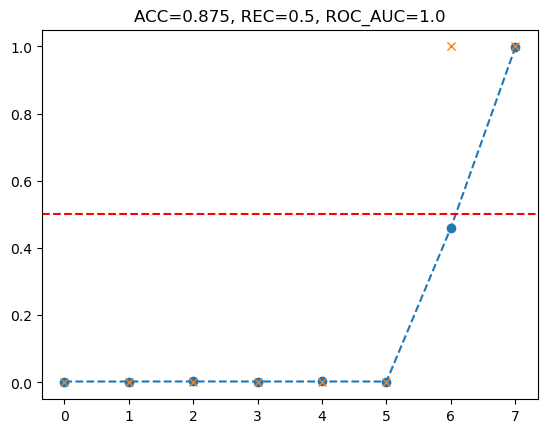

In [299]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 2.7398622, -3.1098123],
     [ 0.0657177, -0.0930362],
     [-2.7668718,  3.0918367]]
)
labels = np.array([0,0,0,0,0,0,1,1])
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
plt.plot(probabilities[:,1],'--o')
plt.plot(labels,'x')
plt.axhline(y=0.5, color='red', linestyle='--')
roc_auc = evaluate.load("roc_auc")
acc = evaluate.load("accuracy")
rec = evaluate.load("recall")
results = {
    'accuracy': acc.compute(predictions= logits.argmax(axis=1), references=labels)['accuracy'],
    'recall': rec.compute(predictions= logits.argmax(axis=1), references=labels)['recall'],
    'roc_auc': roc_auc.compute(references= labels, prediction_scores= probabilities[:,1])['roc_auc']
}
plt.title(f"ACC={results['accuracy']}, REC={results['recall']}, ROC_AUC={results['roc_auc']}")

Text(0.5, 1.0, 'ACC=0.875, REC=0.5, ROC_AUC=0.5833333333333333')

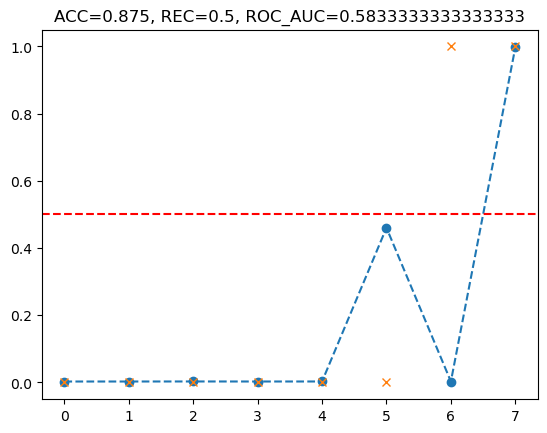

In [301]:
logits = np.array(
    [[ 2.7346244, -3.1177292],
     [ 2.7103324, -3.1362345],
     [ 2.7464483, -3.0521457],
     [ 2.7195318, -3.122628 ],
     [ 2.7138977, -3.1041346],
     [ 0.0657177, -0.0930362],     
     [ 2.7398622, -3.1098123],
     [-2.7668718,  3.0918367]]
)
labels = np.array([0,0,0,0,0,0,1,1])
probabilities = torch.tensor(logits).softmax(dim=1).numpy()
plt.plot(probabilities[:,1],'--o')
plt.plot(labels,'x')
plt.axhline(y=0.5, color='red', linestyle='--')
roc_auc = evaluate.load("roc_auc")
acc = evaluate.load("accuracy")
rec = evaluate.load("recall")
results = {
    'accuracy': acc.compute(predictions= logits.argmax(axis=1), references=labels)['accuracy'],
    'recall': rec.compute(predictions= logits.argmax(axis=1), references=labels)['recall'],
    'roc_auc': roc_auc.compute(references= labels, prediction_scores= probabilities[:,1])['roc_auc']
}
plt.title(f"ACC={results['accuracy']}, REC={results['recall']}, ROC_AUC={results['roc_auc']}")

# 6. 분석

`-` `train.csv`를 pandas로

In [10]:
train_csv = pd.read_csv("./data/train.csv")
train_csv

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
...,...,...
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0


In [11]:
test_csv = pd.read_csv("./data/sample_submission.csv")
test_csv

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5
...,...,...
3995,ffaafd0c9f2f0e73172848463bc2e523.jpg,0.5
3996,ffae37344310a1549162493237d25d3f.jpg,0.5
3997,ffbd469c56873d064326204aac546e0d.jpg,0.5
3998,ffcb76b7d47f29ece11c751e5f763f52.jpg,0.5


## A. 예쁜(?) 정석 코드

*Step1: Data*

In [418]:
ctx_train = datasets.Dataset.from_pandas(train_csv)
ctx_test = datasets.Dataset.from_pandas(test_csv).remove_columns(['has_cactus'])

In [419]:
ctx_train = ctx_train.map(lambda example: {'path': f'./data/train/{example['id']}'})
ctx_test = ctx_test.map(lambda example: {'path': f'./data/test/{example['id']}'})

Map: 100%|████████████████████████| 4000/4000 [00:00<00:00, 92217.97 examples/s]


In [420]:
ctx = datasets.DatasetDict({'train':ctx_train,'test':ctx_test})
ctx

DatasetDict({
    train: Dataset({
        features: ['id', 'has_cactus', 'path'],
        num_rows: 17500
    })
    test: Dataset({
        features: ['id', 'path'],
        num_rows: 4000
    })
})

In [421]:
compose('./data/train/0004be2cfeaba1c0361d39e2b000257b.jpg')

tensor([[[0.5333, 0.5333, 0.5333,  ..., 0.6157, 0.6157, 0.6157],
         [0.5333, 0.5333, 0.5333,  ..., 0.6157, 0.6157, 0.6157],
         [0.5333, 0.5333, 0.5333,  ..., 0.6157, 0.6157, 0.6157],
         ...,
         [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451],
         [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451],
         [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451]],

        [[0.5412, 0.5412, 0.5412,  ..., 0.5255, 0.5255, 0.5255],
         [0.5412, 0.5412, 0.5412,  ..., 0.5255, 0.5255, 0.5255],
         [0.5412, 0.5412, 0.5412,  ..., 0.5255, 0.5255, 0.5255],
         ...,
         [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314],
         [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314],
         [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314]],

        [[0.4902, 0.4902, 0.4902,  ..., 0.5490, 0.5490, 0.5490],
         [0.4902, 0.4902, 0.4902,  ..., 0.5490, 0.5490, 0.5490],
         [0.4902, 0.4902, 0.4902,  ..., 0.5490, 0.5490, 0.

In [422]:
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224),
])
def w_trans(examples):
    dct = dict()
    try: 
        dct['labels'] = torch.tensor(examples['has_cactus']).long()
    except: 
        pass 
    dct['pixel_values'] = torch.stack(list(map(compose,examples['path']))).float() # 명확하게
    return dct 

In [423]:
ctx = ctx.with_transform(w_trans)
ctx

DatasetDict({
    train: Dataset({
        features: ['id', 'has_cactus', 'path'],
        num_rows: 17500
    })
    test: Dataset({
        features: ['id', 'path'],
        num_rows: 4000
    })
})

In [424]:
ctx['train'][:2]

{'labels': tensor([1, 1]),
 'pixel_values': tensor([[[[0.5333, 0.5333, 0.5333,  ..., 0.6157, 0.6157, 0.6157],
           [0.5333, 0.5333, 0.5333,  ..., 0.6157, 0.6157, 0.6157],
           [0.5333, 0.5333, 0.5333,  ..., 0.6157, 0.6157, 0.6157],
           ...,
           [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451],
           [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451],
           [0.7176, 0.7176, 0.7176,  ..., 0.5451, 0.5451, 0.5451]],
 
          [[0.5412, 0.5412, 0.5412,  ..., 0.5255, 0.5255, 0.5255],
           [0.5412, 0.5412, 0.5412,  ..., 0.5255, 0.5255, 0.5255],
           [0.5412, 0.5412, 0.5412,  ..., 0.5255, 0.5255, 0.5255],
           ...,
           [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314],
           [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314],
           [0.6157, 0.6157, 0.6157,  ..., 0.4314, 0.4314, 0.4314]],
 
          [[0.4902, 0.4902, 0.4902,  ..., 0.5490, 0.5490, 0.5490],
           [0.4902, 0.4902, 0.4902,  ..., 0.5490

*Step2: Model*

In [425]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*Step3: Train*

In [426]:
data_collator = transformers.DefaultDataCollator()
data_collator

DefaultDataCollator(return_tensors='pt')

In [427]:
# single_batch = [ctx['train'][0],ctx['train'][1]]
# single_batch = [ctx['test'][0],ctx['test'][1]]
# model(**data_collator(single_batch))

In [428]:
ctx

DatasetDict({
    train: Dataset({
        features: ['id', 'has_cactus', 'path'],
        num_rows: 17500
    })
    test: Dataset({
        features: ['id', 'path'],
        num_rows: 4000
    })
})

In [429]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    prediction_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    #---#
    accuracy = evaluate.load("accuracy")
    recall = evaluate.load("recall")
    roc_auc = evaluate.load("roc_auc")
    dct1 = accuracy.compute(predictions=predictions, references=labels)
    dct2 = recall.compute(predictions=predictions, references=labels)
    dct3 = roc_auc.compute(prediction_scores=prediction_scores, references=labels)
    return dct1|dct2|dct3
args = transformers.TrainingArguments(
    output_dir="./model/ctx",
    remove_unused_columns=False,
    #---#
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    #metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"
)
trainer = transformers.Trainer(
    model=model,
    args=args,
    data_collator=data_collator,
    train_dataset=ctx['train'].select(range(1000)),
    eval_dataset=ctx['train'].select(range(1000,1500)),
    compute_metrics=compute_metrics,
)

In [430]:
ctx

DatasetDict({
    train: Dataset({
        features: ['id', 'has_cactus', 'path'],
        num_rows: 17500
    })
    test: Dataset({
        features: ['id', 'path'],
        num_rows: 4000
    })
})

In [431]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Recall,Roc Auc
0,0.486200,0.270196,0.956000,1.000000,0.998761


TrainOutput(global_step=15, training_loss=0.4222262461980184, metrics={'train_runtime': 14.1654, 'train_samples_per_second': 70.594, 'train_steps_per_second': 1.059, 'total_flos': 7.439231003000832e+16, 'train_loss': 0.4222262461980184, 'epoch': 0.9523809523809523})

*Step4: Prediction*

In [432]:
out = trainer.predict(ctx['test'])
out 

PredictionOutput(predictions=array([[-0.87309086,  0.76549405],
       [-0.9422926 ,  1.0070752 ],
       [-0.02508726, -0.12881294],
       ...,
       [-1.0198429 ,  1.0380617 ],
       [-1.0059347 ,  0.9955274 ],
       [-0.8788617 ,  0.75964546]], dtype=float32), label_ids=None, metrics={'test_runtime': 10.9475, 'test_samples_per_second': 365.379, 'test_steps_per_second': 22.836})

In [433]:
logits = out.predictions
prob = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
prob

array([0.83734226, 0.8753777 , 0.4740918 , ..., 0.8867439 , 0.8809505 ,
       0.83733165], dtype=float32)

In [434]:
test_csv['has_cactus'] = prob 
test_csv

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.837342
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.875378
2,001ee6d8564003107853118ab87df407.jpg,0.474092
3,002e175c3c1e060769475f52182583d0.jpg,0.429720
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.862989
...,...,...
3995,ffaafd0c9f2f0e73172848463bc2e523.jpg,0.866051
3996,ffae37344310a1549162493237d25d3f.jpg,0.902185
3997,ffbd469c56873d064326204aac546e0d.jpg,0.886744
3998,ffcb76b7d47f29ece11c751e5f763f52.jpg,0.880951


*Step1 ~ Step4*

In [436]:
train_csv = pd.read_csv("./data/train.csv")
test_csv = pd.read_csv("./data/sample_submission.csv")
#--#
# Step1: Data
ctx_train = datasets.Dataset.from_pandas(train_csv)
ctx_test = datasets.Dataset.from_pandas(test_csv).remove_columns(['has_cactus'])
ctx_train = ctx_train.map(lambda example: {'path': f'./data/train/{example['id']}'})
ctx_test = ctx_test.map(lambda example: {'path': f'./data/test/{example['id']}'})
ctx = datasets.DatasetDict({'train':ctx_train,'test':ctx_test})
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224),
])
def w_trans(examples):
    dct = dict()
    try: 
        dct['labels'] = torch.tensor(examples['has_cactus']).long()
    except: 
        pass 
    dct['pixel_values'] = torch.stack(list(map(compose,examples['path']))).float() # 명확하게
    return dct 
ctx = ctx.with_transform(w_trans)
# Step2: Model 
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
)
# Step3: Train 
data_collator = transformers.DefaultDataCollator()
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    prediction_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    #---#
    accuracy = evaluate.load("accuracy")
    recall = evaluate.load("recall")
    roc_auc = evaluate.load("roc_auc")
    dct1 = accuracy.compute(predictions=predictions, references=labels)
    dct2 = recall.compute(predictions=predictions, references=labels)
    dct3 = roc_auc.compute(prediction_scores=prediction_scores, references=labels)
    return dct1|dct2|dct3
trainer = transformers.Trainer(
    model=model,
    args=transformers.TrainingArguments(
        output_dir="./model/ctx",
        remove_unused_columns=False,
        #---#
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        warmup_ratio=0.1,
        logging_steps=10,
        load_best_model_at_end=True,
        #metric_for_best_model="accuracy",
        push_to_hub=False,
        report_to="none"),
    data_collator=data_collator,
    train_dataset=ctx['train'].select(range(1000)),
    eval_dataset=ctx['train'].select(range(1000,1500)),
    compute_metrics=compute_metrics,
)
trainer.train()
# Step4: Prediction
out = trainer.predict(ctx['test'])
def update(out,test_csv):
    logits = out.predictions
    prob = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    test_csv['has_cactus'] = prob
    return test_csv
test_csv = update(out,test_csv)

Map: 100%|████████████████████████| 4000/4000 [00:00<00:00, 91609.69 examples/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Roc Auc
0,0.500400,0.204903,0.970000,0.997312,0.999223
1,0.111500,0.110077,0.990000,0.994624,0.999748


## B. 자유로운 코드

*Step1: Datasets*

In [408]:
train_csv = pd.read_csv("./data/train.csv")
test_csv = pd.read_csv("./data/sample_submission.csv")
ctx_train = datasets.Dataset.from_pandas(train_csv.assign(path = train_csv.id.map(lambda x: f'./data/train/{x}')))
ctx_test = datasets.Dataset.from_pandas(test_csv.assign(path = test_csv.id.map(lambda x: f'./data/test/{x}'))).remove_columns(['has_cactus'])
ctx = datasets.DatasetDict({'train':ctx_train, 'test':ctx_test})
ctx

DatasetDict({
    train: Dataset({
        features: ['id', 'has_cactus', 'path'],
        num_rows: 17500
    })
    test: Dataset({
        features: ['id', 'path'],
        num_rows: 4000
    })
})

*Step2~3 과정의 간보기*

In [416]:
## 간보기코드
single_batch = [ctx['train'][0],ctx['train'][1]]
single_batch
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224),
])
def collate_fn(single_batch):
    dct = dict()
    dct['pixel_values'] = torch.stack(list(map(compose,[o['path'] for o in single_batch]))).float()
    try: 
        dct['labels'] = torch.tensor([o.get('has_cactus') for o in single_batch]).long() # 이거안하면 에러남
    except: 
        pass 
    return dct 
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
)
model(**collate_fn(single_batch))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImageClassifierOutput(loss=tensor(0.6570, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0427,  0.2046],
        [-0.0234, -0.0343]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

*Step1~4*

In [438]:
train_csv = pd.read_csv("./data/train.csv")
test_csv = pd.read_csv("./data/sample_submission.csv")
#--#
# Step1: Data 
ctx_train = datasets.Dataset.from_pandas(train_csv.assign(path = train_csv.id.map(lambda x: f'./data/train/{x}')))
ctx_test = datasets.Dataset.from_pandas(test_csv.assign(path = test_csv.id.map(lambda x: f'./data/test/{x}'))).remove_columns(['has_cactus'])
ctx = datasets.DatasetDict({'train':ctx_train, 'test':ctx_test})
compose = torchvision.transforms.Compose([
    lambda path: PIL.Image.open(path),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224),
])
# Step2: Model
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2,
)
# Step3: Trainer -> train 
def collate_fn(single_batch):
    dct = dict()
    dct['pixel_values'] = torch.stack(list(map(compose,[o['path'] for o in single_batch]))).float()
    try: 
        dct['labels'] = torch.tensor([o.get('has_cactus') for o in single_batch]).long() # 이거안하면 에러남
    except: 
        pass 
    return dct 
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    prediction_scores = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    #---#
    accuracy = evaluate.load("accuracy")
    recall = evaluate.load("recall")
    roc_auc = evaluate.load("roc_auc")
    dct1 = accuracy.compute(predictions=predictions, references=labels)
    dct2 = recall.compute(predictions=predictions, references=labels)
    dct3 = roc_auc.compute(prediction_scores=prediction_scores, references=labels)
    return dct1|dct2|dct3
trainer = transformers.Trainer(
    model=model,
    args=transformers.TrainingArguments(
        output_dir="./model/ctx",
        remove_unused_columns=False,
        #---#
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        warmup_ratio=0.1,
        logging_steps=10,
        load_best_model_at_end=True,
        #metric_for_best_model="accuracy",
        push_to_hub=False,
        report_to="none"),
    data_collator=collate_fn,
    train_dataset=ctx['train'].select(range(1000)),
    eval_dataset=ctx['train'].select(range(1000,1500)),
    compute_metrics=compute_metrics,
)
trainer.train()
# Step4: Prediction
out = trainer.predict(ctx['test'])
def update(out,test_csv):
    logits = out.predictions
    prob = torch.tensor(logits).softmax(dim=1).numpy()[:,1]
    test_csv['has_cactus'] = prob
    return test_csv
test_csv = update(out,test_csv)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Roc Auc
0,0.499300,0.276025,0.918000,1.000000,0.999286
